# Imports

In [2]:
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

from collections import Counter
from IPython.core.display import display, HTML

# Settings

In [3]:
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))

# Getting data

In [4]:
%%time
response = requests.get('http://wfs-kbhkort.kk.dk/k101/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=k101:trae_basis&outputFormat=csv&SRSNAME=EPSG:4326')

In [5]:
file_buffer = io.StringIO(response.text)
df = pd.read_csv(file_buffer, sep=',', dtype=object)
df[df.planteaar.notnull()].head()

,FID,kategori,saerligt_trae,id,type,element,under_element,arbsted_tekst_id,driftsplan_navn,enhedsomraade,traeart,dansk_navn,slaegtsnavn,planteaar,plantet_halvaar,faeldningsaar,bydelsnavn,omraade,vejnavn,vejklasse,vejstatus,fritrumsprofil,stammeomfang,kronediameter,placering,afgraensning,plantemetode,omgivelse,vaekstmedie,beskyttelse,sundhed,skudtilvaekst,andre_vaekstforhold,bevaringsvaerdi,registrering_type,driftstatus_gadetrae,ejer,driftsorganisation,garantiperioden_udloeber,driftsaftale_edoc_nr,fredet_beskyttet_trae,fredningsmyndighed,trae_historie,botanisk_interesse,fredet_trae_foto,donor,anledning,saerlig_trae_bem,fredning_edoc_nr,ikonisk_trae,evighedstrae,bemaerkning,reg_dato,opdateret_dato,r_tidsstempel,r_risikofaktor,r_vaerdi,r_omgivelser,r_registrant,r_registreringsnummer,r_aendringer_rodzone_andet,r_gravearbejde_i_rodzonen,r_gravearbejde_dato,r_graveansvarlig,r_terraenaendring,r_terraenaendring_dato,r_belaegningsaendring_rodzonen,r_belaegningsaendring_dato,r_beplantningsaendring,r_beplantningsaendring_dato,r_aendring_i_graespleje,r_aendring_i_graespleje_dato,r_grundvandsaendring,r_grundvandsaendring_dato,r_sygdomme_skadedyr_andet,r_sygdomme,r_skadedyr,r_stammestruktur_andet,r_tvege,r_flerstammet,r_haeldning,r_kronestruktur_andet,r_ensidig,r_spidse_grenvinkler,r_lange_tunge_grene,r_stammeagtige_sidegrene,r_svag_grensammenhaeftning,r_kronen_andet,r_unormal_bladstoerrelse,r_tidligt_bladtab_hoestfarver,r_grene_mange_saar,r_saar_kritiske_steder_krone,r_daarlig_saarheling_krone,r_doede_grene_braekket_revne,r_revner_i_grene,r_maengden_af_doede_grene,r_stoerrelse_defekte_grene,r_toptoerhed,r_tyndloevet,r_beskaering,r_doedt_trae_staaende,r_stammen_andet,r_doed_bark,r_unormal_bark,r_slimflaad,r_indsunken_bark,r_indvokset_bark,r_store_gamle_saar,r_mange_saar_paa_stammen,r_saar_kritiske_steder_stamme,r_daarlig_saarheling_stamme,r_revner,r_defekter,r_stammeraad_hulhed_aaben,r_stammeraad_hulhed_lukket,r_rodzonen_andet,r_overfladisk_rodnet,r_omvoksende_roedder,r_rodskader,r_rodkageloesning,r_svamp_andet,r_honningsvamp,r_krumskaellet_skaelhat,r_kulsvamp,r_kaempe_poresvamp,r_lakporesvamp,r_skaellet_stilkporesvamp,r_svovlporesvamp,r_toendersvamp,r_oestershat,r_floejlsfod,r_laedersvamp,r_ukendt_svamp,r_ukendt_svamp_beskrivelse,r_birkeporesvamp,r_tilsynsaarsag_andet,r_kronesymptomer,r_struktur,r_svamp,r_skade_paa_roedder,r_raadmaaling_andet,r_raadmaaling_dato,r_naeste_raadmaaling_aar,r_undersoegelse_lift_andet,r_undersoegelse_lift_dato,r_handling_andet,r_handling,r_tid_for_handling,r_beskaeringsaar,r_tilsynsfrekvens,r_naeste_tilsyn_halvaar,r_skader_andet,r_materiel,r_person,r_link_til_edoc_sag,r_generelt_beplantning_andet,r_handling_for_beplantning,r_img01,r_img02,r_img03,r_img04,r_img05,r_img06,r_img07,r_img08,r_img09,r_img10,r_img11,r_img12,r_img13,r_img14,r_img15,torso_hoejde,torso_omkreds,torso_stamme,torso_sidst_stynet,torso_frekvens_styning,torso_naeste_styning,torso_skaeres_ned_til,torso_bemaerkning,wkb_geometry
3,trae_basis.7048,privat træ,nej,3460,2 Træer,2.1 Fuldkronede gade- og torvetræer,NaN,NaN,Gadetrae private,Nordvest,Acer platanoides,Spidsløn,Løn,1970,Ikke registreret,Ikke registreret,Vanløse,Center Drift Nord CDN,Borups Allé,lokal vej,Kommunevej,"4,5 m",40 - 60,Ikke registreret,Siderabat,Uden kant,Muld,Fast belægning,Ikke registreret,Ikke registreret,God,Ikke registreret,NaN,Ikke registreret,Gadetræ registreret før sommer 2009,Ikke registreret,Privat,Privat,Ikke registreret,NaN,Ikke registreret,Ikke registreret,Ikke registreret,Ikke registreret,NaN,NaN,NaN,NaN,NaN,NaN,Ikke registreret,Vejdirektoratet,2011-07-01T00:00:00,2019-02-22T12:04:24.408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# Prepare data

In [26]:
stammeomfang_translator = {
    'Ikke registreret': np.nan,
    '40 - 60': 50,
    '30 - 40': 35,
    '< 18': 10,
    '20 - 25': 22.5,
    '18 - 20': 19,
    '25 - 30': 27.5,
    '> 60': 80
}
def extract_data(row):
    # Coordinates
    lon, lat = row['wkb_geometry'].split(' ')[1][1:], row['wkb_geometry'].split(' ')[2][:-1]
    # Year
    try:
        year = int(row['planteaar'])
    except:
        year = np.nan
    # Stammeomfang
    stammeomfang = stammeomfang_translator[row['stammeomfang']]
    # Area
    area = row['enhedsomraade']
    # Street type
    streettype = row['vejklasse']

    return {'lon': float(lon), 'lat': float(lat), 'year': year, 'stammeomfang': stammeomfang, 'enhedsomraade': area, 'vejklasse': streettype}

plotting_data = []
for extracted_data in df.apply(lambda x: extract_data(x), axis=1):
    plotting_data.append(extracted_data)

plotting_df = pd.DataFrame(plotting_data)

plotting_df.head()

,enhedsomraade,lat,lon,stammeomfang,vejklasse,year
0,Valby,55.649008,12.490139,NaN,Ikke registreret,NaN
1,Østerbro,55.703687,12.570052,NaN,Ikke registreret,NaN
2,Nørrebro,55.682469,12.555327,NaN,Ikke registreret,NaN
3,Nordvest,55.704793,12.516774,50.0,lokal vej,1970.0
4,Valby,55.648846,12.490368,NaN,Ikke registreret,NaN


# Trees by planted year

In [27]:
years = []
counts = []
for year, count in Counter(df.planteaar).most_common():
    try:
        int(year)
    except:
        continue
    years.append(year)
    counts.append(count)


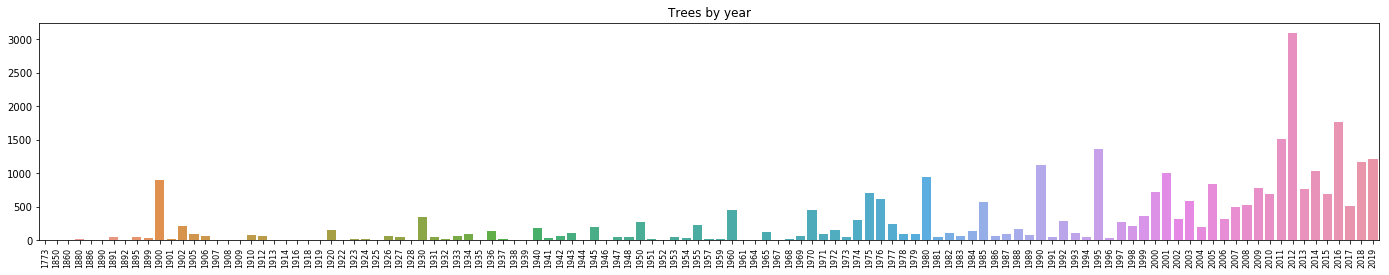

In [7]:
plt.figure(figsize=(24, 4))
sns.barplot(x=years, y=counts)
plt.xticks(rotation=90, fontsize=8)
plt.title('Trees by year')
plt.show()

# Tree location and size

(23400, 6)


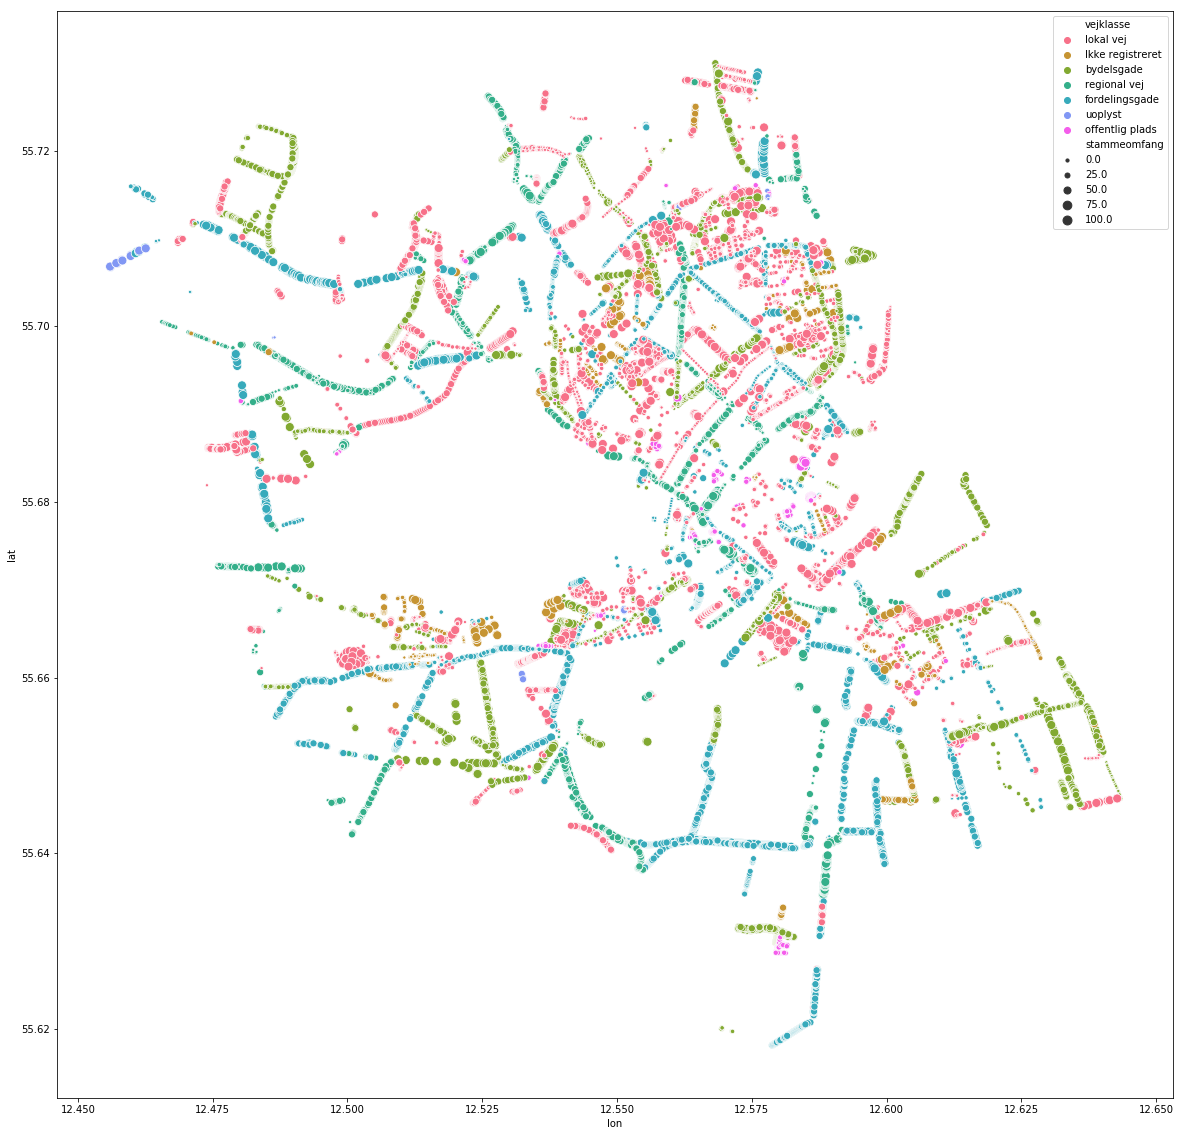

In [43]:
plt.figure(figsize=(20, 20))
#cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
#cmap = sns.light_palette("seagreen", as_cmap=True)
hue_variable = 'vejklasse'
cmap = sns.color_palette("husl", n_colors=len(plotting_df[hue_variable].unique()))
plotting_df = plotting_df.dropna()
print(plotting_df.shape)

mask = df.isnull()
ax = sns.scatterplot(x="lon", y="lat",
                     hue=hue_variable,
                     size="stammeomfang",
                     palette=cmap,
                     sizes=(10, 80),
                     data=plotting_df)
plt.show()

In [70]:
print('Gennemsnitlig stammeomfang: ', plotting_df.stammeomfang.mean())
grouping_variable = 'vejklasse' # Try 'year'
display(plotting_df[[grouping_variable, 'stammeomfang']].groupby(grouping_variable).mean())

Gennemsnitlig stammeomfang:  37.4625


,stammeomfang
vejklasse,
Ikke registreret,32.599865
bydelsgade,37.310811
fordelingsgade,39.296970
lokal vej,36.584675
offentlig plads,32.585008
regional vej,40.199091
uoplyst,46.375000


# Add your plot here 😎

In [61]:
print('...')

...
